In [50]:
# group plays by game
# process each game for five factors diff
# get df of ff diff and point diff
# run lin reg
# check against other more recent games

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
    
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2019):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

In [51]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 2511
Total Drives: 64612
Total Plays: 455669


In [52]:
# Data cleaning
base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

Clean Drives: 44508


In [53]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [88]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr]
    })

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to]
    })

def stringify_entry(team_entry):
    return team_entry.tolist()[0]

def calculate_five_factors_rating(team_stat_pack):
    return (.35 * team_stat_pack.OffSR) + (.25 * (team_stat_pack.OffER * team_stat_pack.YPP)) + (.15 * (team_stat_pack.FP / 50.0)) + (.15 * ((team_stat_pack.PPD + team_stat_pack.OppSR + team_stat_pack.OppEff)/3)) + (.10 * team_stat_pack.ExpTODiff)

def calculate_box_score(game_id):
    game_data = games[games.id == game_id]
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_drives = drives[drives.game_id == game_id]
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"ESPN {game_id} has no play by play data, need to double check entry")
        return None

    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183)

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0.375000,0.071429,28.1,4.192982,3.1,0.75,0.4,0.515152,1.15,0.22,0.530682,0.002109
1,Virginia Tech,34,3,0.124335,0.396825,0.079365,26.3,5.492308,3.4,0.60,0.5,0.476190,0.93,-0.22,0.528573,-0.002109


In [89]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i in range(len(game_ids)):
    gameId = game_ids[i]
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    box_score = calculate_box_score(gameId)
    if (box_score is not None):
        game_tms = box_score.Team.tolist()
        print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
        if ((game_tms[0] in team_list) & (game_tms[1] in team_list)):
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping aggreggation for game_id {gameId} bc one of the teams isn't FBS")
    else:
        print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")

[1/2511] Getting game information for ESPN game_id: 400869090
[1/2511] Started processing game information for ESPN game_id: 400869090
ESPN 400869090 has no play by play data, need to double check entry
[1/2511] Got 'None' for game_id 400869090's box score, skipping processing
[2/2511] Getting game information for ESPN game_id: 400869421
[2/2511] Started processing game information for ESPN game_id: 400869421
ESPN 400869421 has no play by play data, need to double check entry
[2/2511] Got 'None' for game_id 400869421's box score, skipping processing
[3/2511] Getting game information for ESPN game_id: 400869257
[3/2511] Started processing game information for ESPN game_id: 400869257
ESPN 400869257 has no play by play data, need to double check entry
[3/2511] Got 'None' for game_id 400869257's box score, skipping processing
[4/2511] Getting game information for ESPN game_id: 400869502
[4/2511] Started processing game information for ESPN game_id: 400869502
ESPN 400869502 has no play by p

ESPN 400869262 has no play by play data, need to double check entry
[47/2511] Got 'None' for game_id 400869262's box score, skipping processing
[48/2511] Getting game information for ESPN game_id: 400869652
[48/2511] Started processing game information for ESPN game_id: 400869652
ESPN 400869652 has no play by play data, need to double check entry
[48/2511] Got 'None' for game_id 400869652's box score, skipping processing
[49/2511] Getting game information for ESPN game_id: 400869619
[49/2511] Started processing game information for ESPN game_id: 400869619
ESPN 400869619 has no play by play data, need to double check entry
[49/2511] Got 'None' for game_id 400869619's box score, skipping processing
[50/2511] Getting game information for ESPN game_id: 400869427
[50/2511] Started processing game information for ESPN game_id: 400869427
ESPN 400869427 has no play by play data, need to double check entry
[50/2511] Got 'None' for game_id 400869427's box score, skipping processing
[51/2511] Get

ESPN 400869633 has no play by play data, need to double check entry
[94/2511] Got 'None' for game_id 400869633's box score, skipping processing
[95/2511] Getting game information for ESPN game_id: 400869510
[95/2511] Started processing game information for ESPN game_id: 400869510
ESPN 400869510 has no play by play data, need to double check entry
[95/2511] Got 'None' for game_id 400869510's box score, skipping processing
[96/2511] Getting game information for ESPN game_id: 400868911
[96/2511] Started processing game information for ESPN game_id: 400868911
ESPN 400868911 has no play by play data, need to double check entry
[96/2511] Got 'None' for game_id 400868911's box score, skipping processing
[97/2511] Getting game information for ESPN game_id: 400868990
[97/2511] Started processing game information for ESPN game_id: 400868990
ESPN 400868990 has no play by play data, need to double check entry
[97/2511] Got 'None' for game_id 400868990's box score, skipping processing
[98/2511] Get

ESPN 400869273 has no play by play data, need to double check entry
[141/2511] Got 'None' for game_id 400869273's box score, skipping processing
[142/2511] Getting game information for ESPN game_id: 400868987
[142/2511] Started processing game information for ESPN game_id: 400868987
ESPN 400868987 has no play by play data, need to double check entry
[142/2511] Got 'None' for game_id 400868987's box score, skipping processing
[143/2511] Getting game information for ESPN game_id: 400869612
[143/2511] Started processing game information for ESPN game_id: 400869612
ESPN 400869612 has no play by play data, need to double check entry
[143/2511] Got 'None' for game_id 400869612's box score, skipping processing
[144/2511] Getting game information for ESPN game_id: 400868981
[144/2511] Started processing game information for ESPN game_id: 400868981
ESPN 400868981 has no play by play data, need to double check entry
[144/2511] Got 'None' for game_id 400868981's box score, skipping processing
[14

ESPN 400869437 has no play by play data, need to double check entry
[189/2511] Got 'None' for game_id 400869437's box score, skipping processing
[190/2511] Getting game information for ESPN game_id: 400869197
[190/2511] Started processing game information for ESPN game_id: 400869197
ESPN 400869197 has no play by play data, need to double check entry
[190/2511] Got 'None' for game_id 400869197's box score, skipping processing
[191/2511] Getting game information for ESPN game_id: 400868959
[191/2511] Started processing game information for ESPN game_id: 400868959
ESPN 400868959 has no play by play data, need to double check entry
[191/2511] Got 'None' for game_id 400868959's box score, skipping processing
[192/2511] Getting game information for ESPN game_id: 400869282
[192/2511] Started processing game information for ESPN game_id: 400869282
ESPN 400869282 has no play by play data, need to double check entry
[192/2511] Got 'None' for game_id 400869282's box score, skipping processing
[19

ESPN 400869448 has no play by play data, need to double check entry
[236/2511] Got 'None' for game_id 400869448's box score, skipping processing
[237/2511] Getting game information for ESPN game_id: 400869200
[237/2511] Started processing game information for ESPN game_id: 400869200
ESPN 400869200 has no play by play data, need to double check entry
[237/2511] Got 'None' for game_id 400869200's box score, skipping processing
[238/2511] Getting game information for ESPN game_id: 400869002
[238/2511] Started processing game information for ESPN game_id: 400869002
ESPN 400869002 has no play by play data, need to double check entry
[238/2511] Got 'None' for game_id 400869002's box score, skipping processing
[239/2511] Getting game information for ESPN game_id: 400869634
[239/2511] Started processing game information for ESPN game_id: 400869634
ESPN 400869634 has no play by play data, need to double check entry
[239/2511] Got 'None' for game_id 400869634's box score, skipping processing
[24

ESPN 400869366 has no play by play data, need to double check entry
[283/2511] Got 'None' for game_id 400869366's box score, skipping processing
[284/2511] Getting game information for ESPN game_id: 400869008
[284/2511] Started processing game information for ESPN game_id: 400869008
ESPN 400869008 has no play by play data, need to double check entry
[284/2511] Got 'None' for game_id 400869008's box score, skipping processing
[285/2511] Getting game information for ESPN game_id: 400869205
[285/2511] Started processing game information for ESPN game_id: 400869205
ESPN 400869205 has no play by play data, need to double check entry
[285/2511] Got 'None' for game_id 400869205's box score, skipping processing
[286/2511] Getting game information for ESPN game_id: 400869120
[286/2511] Started processing game information for ESPN game_id: 400869120
ESPN 400869120 has no play by play data, need to double check entry
[286/2511] Got 'None' for game_id 400869120's box score, skipping processing
[28

ESPN 400869015 has no play by play data, need to double check entry
[332/2511] Got 'None' for game_id 400869015's box score, skipping processing
[333/2511] Getting game information for ESPN game_id: 400869372
[333/2511] Started processing game information for ESPN game_id: 400869372
ESPN 400869372 has no play by play data, need to double check entry
[333/2511] Got 'None' for game_id 400869372's box score, skipping processing
[334/2511] Getting game information for ESPN game_id: 400869371
[334/2511] Started processing game information for ESPN game_id: 400869371
ESPN 400869371 has no play by play data, need to double check entry
[334/2511] Got 'None' for game_id 400869371's box score, skipping processing
[335/2511] Getting game information for ESPN game_id: 400869010
[335/2511] Started processing game information for ESPN game_id: 400869010
ESPN 400869010 has no play by play data, need to double check entry
[335/2511] Got 'None' for game_id 400869010's box score, skipping processing
[33

ESPN 400869023 has no play by play data, need to double check entry
[381/2511] Got 'None' for game_id 400869023's box score, skipping processing
[382/2511] Getting game information for ESPN game_id: 400868914
[382/2511] Started processing game information for ESPN game_id: 400868914
ESPN 400868914 has no play by play data, need to double check entry
[382/2511] Got 'None' for game_id 400868914's box score, skipping processing
[383/2511] Getting game information for ESPN game_id: 400869132
[383/2511] Started processing game information for ESPN game_id: 400869132
ESPN 400869132 has no play by play data, need to double check entry
[383/2511] Got 'None' for game_id 400869132's box score, skipping processing
[384/2511] Getting game information for ESPN game_id: 400869020
[384/2511] Started processing game information for ESPN game_id: 400869020
ESPN 400869020 has no play by play data, need to double check entry
[384/2511] Got 'None' for game_id 400869020's box score, skipping processing
[38

ESPN 400869028 has no play by play data, need to double check entry
[430/2511] Got 'None' for game_id 400869028's box score, skipping processing
[431/2511] Getting game information for ESPN game_id: 400869463
[431/2511] Started processing game information for ESPN game_id: 400869463
ESPN 400869463 has no play by play data, need to double check entry
[431/2511] Got 'None' for game_id 400869463's box score, skipping processing
[432/2511] Getting game information for ESPN game_id: 400869306
[432/2511] Started processing game information for ESPN game_id: 400869306
ESPN 400869306 has no play by play data, need to double check entry
[432/2511] Got 'None' for game_id 400869306's box score, skipping processing
[433/2511] Getting game information for ESPN game_id: 400869723
[433/2511] Started processing game information for ESPN game_id: 400869723
ESPN 400869723 has no play by play data, need to double check entry
[433/2511] Got 'None' for game_id 400869723's box score, skipping processing
[43

ESPN 400869225 has no play by play data, need to double check entry
[478/2511] Got 'None' for game_id 400869225's box score, skipping processing
[479/2511] Getting game information for ESPN game_id: 400869470
[479/2511] Started processing game information for ESPN game_id: 400869470
ESPN 400869470 has no play by play data, need to double check entry
[479/2511] Got 'None' for game_id 400869470's box score, skipping processing
[480/2511] Getting game information for ESPN game_id: 400869143
[480/2511] Started processing game information for ESPN game_id: 400869143
ESPN 400869143 has no play by play data, need to double check entry
[480/2511] Got 'None' for game_id 400869143's box score, skipping processing
[481/2511] Getting game information for ESPN game_id: 400869311
[481/2511] Started processing game information for ESPN game_id: 400869311
ESPN 400869311 has no play by play data, need to double check entry
[481/2511] Got 'None' for game_id 400869311's box score, skipping processing
[48

ESPN 400869592 has no play by play data, need to double check entry
[527/2511] Got 'None' for game_id 400869592's box score, skipping processing
[528/2511] Getting game information for ESPN game_id: 400869621
[528/2511] Started processing game information for ESPN game_id: 400869621
ESPN 400869621 has no play by play data, need to double check entry
[528/2511] Got 'None' for game_id 400869621's box score, skipping processing
[529/2511] Getting game information for ESPN game_id: 400869682
[529/2511] Started processing game information for ESPN game_id: 400869682
ESPN 400869682 has no play by play data, need to double check entry
[529/2511] Got 'None' for game_id 400869682's box score, skipping processing
[530/2511] Getting game information for ESPN game_id: 400869038
[530/2511] Started processing game information for ESPN game_id: 400869038
ESPN 400869038 has no play by play data, need to double check entry
[530/2511] Got 'None' for game_id 400869038's box score, skipping processing
[53

ESPN 400869150 has no play by play data, need to double check entry
[576/2511] Got 'None' for game_id 400869150's box score, skipping processing
[577/2511] Getting game information for ESPN game_id: 400869324
[577/2511] Started processing game information for ESPN game_id: 400869324
ESPN 400869324 has no play by play data, need to double check entry
[577/2511] Got 'None' for game_id 400869324's box score, skipping processing
[578/2511] Getting game information for ESPN game_id: 400869554
[578/2511] Started processing game information for ESPN game_id: 400869554
ESPN 400869554 has no play by play data, need to double check entry
[578/2511] Got 'None' for game_id 400869554's box score, skipping processing
[579/2511] Getting game information for ESPN game_id: 400869236
[579/2511] Started processing game information for ESPN game_id: 400869236
ESPN 400869236 has no play by play data, need to double check entry
[579/2511] Got 'None' for game_id 400869236's box score, skipping processing
[58

ESPN 400869044 has no play by play data, need to double check entry
[624/2511] Got 'None' for game_id 400869044's box score, skipping processing
[625/2511] Getting game information for ESPN game_id: 400869647
[625/2511] Started processing game information for ESPN game_id: 400869647
ESPN 400869647 has no play by play data, need to double check entry
[625/2511] Got 'None' for game_id 400869647's box score, skipping processing
[626/2511] Getting game information for ESPN game_id: 400869555
[626/2511] Started processing game information for ESPN game_id: 400869555
ESPN 400869555 has no play by play data, need to double check entry
[626/2511] Got 'None' for game_id 400869555's box score, skipping processing
[627/2511] Getting game information for ESPN game_id: 400869402
[627/2511] Started processing game information for ESPN game_id: 400869402
ESPN 400869402 has no play by play data, need to double check entry
[627/2511] Got 'None' for game_id 400869402's box score, skipping processing
[62

ESPN 400869159 has no play by play data, need to double check entry
[672/2511] Got 'None' for game_id 400869159's box score, skipping processing
[673/2511] Getting game information for ESPN game_id: 400869846
[673/2511] Started processing game information for ESPN game_id: 400869846
ESPN 400869846 has no play by play data, need to double check entry
[673/2511] Got 'None' for game_id 400869846's box score, skipping processing
[674/2511] Getting game information for ESPN game_id: 400869405
[674/2511] Started processing game information for ESPN game_id: 400869405
ESPN 400869405 has no play by play data, need to double check entry
[674/2511] Got 'None' for game_id 400869405's box score, skipping processing
[675/2511] Getting game information for ESPN game_id: 400869559
[675/2511] Started processing game information for ESPN game_id: 400869559
ESPN 400869559 has no play by play data, need to double check entry
[675/2511] Got 'None' for game_id 400869559's box score, skipping processing
[67

ESPN 400869496 has no play by play data, need to double check entry
[721/2511] Got 'None' for game_id 400869496's box score, skipping processing
[722/2511] Getting game information for ESPN game_id: 400869566
[722/2511] Started processing game information for ESPN game_id: 400869566
ESPN 400869566 has no play by play data, need to double check entry
[722/2511] Got 'None' for game_id 400869566's box score, skipping processing
[723/2511] Getting game information for ESPN game_id: 400869603
[723/2511] Started processing game information for ESPN game_id: 400869603
ESPN 400869603 has no play by play data, need to double check entry
[723/2511] Got 'None' for game_id 400869603's box score, skipping processing
[724/2511] Getting game information for ESPN game_id: 400869696
[724/2511] Started processing game information for ESPN game_id: 400869696
ESPN 400869696 has no play by play data, need to double check entry
[724/2511] Got 'None' for game_id 400869696's box score, skipping processing
[72

ESPN 400868885 has no play by play data, need to double check entry
[770/2511] Got 'None' for game_id 400868885's box score, skipping processing
[771/2511] Getting game information for ESPN game_id: 400869567
[771/2511] Started processing game information for ESPN game_id: 400869567
ESPN 400869567 has no play by play data, need to double check entry
[771/2511] Got 'None' for game_id 400869567's box score, skipping processing
[772/2511] Getting game information for ESPN game_id: 400869167
[772/2511] Started processing game information for ESPN game_id: 400869167
ESPN 400869167 has no play by play data, need to double check entry
[772/2511] Got 'None' for game_id 400869167's box score, skipping processing
[773/2511] Getting game information for ESPN game_id: 400869701
[773/2511] Started processing game information for ESPN game_id: 400869701
ESPN 400869701 has no play by play data, need to double check entry
[773/2511] Got 'None' for game_id 400869701's box score, skipping processing
[77

ESPN 400926947 has no play by play data, need to double check entry
[819/2511] Got 'None' for game_id 400926947's box score, skipping processing
[820/2511] Getting game information for ESPN game_id: 400926948
[820/2511] Started processing game information for ESPN game_id: 400926948
ESPN 400926948 has no play by play data, need to double check entry
[820/2511] Got 'None' for game_id 400926948's box score, skipping processing
[821/2511] Getting game information for ESPN game_id: 400869611
[821/2511] Started processing game information for ESPN game_id: 400869611
ESPN 400869611 has no play by play data, need to double check entry
[821/2511] Got 'None' for game_id 400869611's box score, skipping processing
[822/2511] Getting game information for ESPN game_id: 400869618
[822/2511] Started processing game information for ESPN game_id: 400869618
ESPN 400869618 has no play by play data, need to double check entry
[822/2511] Got 'None' for game_id 400869618's box score, skipping processing
[82

[849/2511] Completed processing game information for ESPN game_id: 400935229
[849/2511] Aggreggating game_id 400935229 to master data copy
[850/2511] Getting game information for ESPN game_id: 400944827
[850/2511] Started processing game information for ESPN game_id: 400944827
ESPN 400944827 has no play by play data, need to double check entry
[850/2511] Got 'None' for game_id 400944827's box score, skipping processing
[851/2511] Getting game information for ESPN game_id: 400941789
[851/2511] Started processing game information for ESPN game_id: 400941789
[851/2511] Completed processing game information for ESPN game_id: 400941789
[851/2511] Aggreggating game_id 400941789 to master data copy
[852/2511] Getting game information for ESPN game_id: 400935247
[852/2511] Started processing game information for ESPN game_id: 400935247
[852/2511] Completed processing game information for ESPN game_id: 400935247
[852/2511] Aggreggating game_id 400935247 to master data copy
[853/2511] Getting ga

[880/2511] Completed processing game information for ESPN game_id: 400944830
[880/2511] Aggreggating game_id 400944830 to master data copy
[881/2511] Getting game information for ESPN game_id: 400934496
[881/2511] Started processing game information for ESPN game_id: 400934496
ESPN 400934496 has no play by play data, need to double check entry
[881/2511] Got 'None' for game_id 400934496's box score, skipping processing
[882/2511] Getting game information for ESPN game_id: 400933832
[882/2511] Started processing game information for ESPN game_id: 400933832
[882/2511] Completed processing game information for ESPN game_id: 400933832
[882/2511] Aggreggating game_id 400933832 to master data copy
[883/2511] Getting game information for ESPN game_id: 400933835
[883/2511] Started processing game information for ESPN game_id: 400933835
ESPN 400933835 has no play by play data, need to double check entry
[883/2511] Got 'None' for game_id 400933835's box score, skipping processing
[884/2511] Gett

[911/2511] Completed processing game information for ESPN game_id: 400933839
[911/2511] Aggreggating game_id 400933839 to master data copy
[912/2511] Getting game information for ESPN game_id: 400941793
[912/2511] Started processing game information for ESPN game_id: 400941793
ESPN 400941793 has no play by play data, need to double check entry
[912/2511] Got 'None' for game_id 400941793's box score, skipping processing
[913/2511] Getting game information for ESPN game_id: 400935253
[913/2511] Started processing game information for ESPN game_id: 400935253
ESPN 400935253 has no play by play data, need to double check entry
[913/2511] Got 'None' for game_id 400935253's box score, skipping processing
[914/2511] Getting game information for ESPN game_id: 400945250
[914/2511] Started processing game information for ESPN game_id: 400945250
ESPN 400945250 has no play by play data, need to double check entry
[914/2511] Got 'None' for game_id 400945250's box score, skipping processing
[915/2511

[941/2511] Completed processing game information for ESPN game_id: 400935262
[941/2511] Aggreggating game_id 400935262 to master data copy
[942/2511] Getting game information for ESPN game_id: 400938605
[942/2511] Started processing game information for ESPN game_id: 400938605
[942/2511] Completed processing game information for ESPN game_id: 400938605
[942/2511] Aggreggating game_id 400938605 to master data copy
[943/2511] Getting game information for ESPN game_id: 400944894
[943/2511] Started processing game information for ESPN game_id: 400944894
ESPN 400944894 has no play by play data, need to double check entry
[943/2511] Got 'None' for game_id 400944894's box score, skipping processing
[944/2511] Getting game information for ESPN game_id: 400944895
[944/2511] Started processing game information for ESPN game_id: 400944895
ESPN 400944895 has no play by play data, need to double check entry
[944/2511] Got 'None' for game_id 400944895's box score, skipping processing
[945/2511] Gett

[971/2511] Completed processing game information for ESPN game_id: 400937458
[971/2511] Aggreggating game_id 400937458 to master data copy
[972/2511] Getting game information for ESPN game_id: 400944893
[972/2511] Started processing game information for ESPN game_id: 400944893
ESPN 400944893 has no play by play data, need to double check entry
[972/2511] Got 'None' for game_id 400944893's box score, skipping processing
[973/2511] Getting game information for ESPN game_id: 400938604
[973/2511] Started processing game information for ESPN game_id: 400938604
ESPN 400938604 has no play by play data, need to double check entry
[973/2511] Got 'None' for game_id 400938604's box score, skipping processing
[974/2511] Getting game information for ESPN game_id: 400938601
[974/2511] Started processing game information for ESPN game_id: 400938601
[974/2511] Completed processing game information for ESPN game_id: 400938601
[974/2511] Aggreggating game_id 400938601 to master data copy
[975/2511] Gett

[1003/2511] Completed processing game information for ESPN game_id: 400937467
[1003/2511] Aggreggating game_id 400937467 to master data copy
[1004/2511] Getting game information for ESPN game_id: 400934517
[1004/2511] Started processing game information for ESPN game_id: 400934517
[1004/2511] Completed processing game information for ESPN game_id: 400934517
[1004/2511] Aggreggating game_id 400934517 to master data copy
[1005/2511] Getting game information for ESPN game_id: 400935352
[1005/2511] Started processing game information for ESPN game_id: 400935352
[1005/2511] Completed processing game information for ESPN game_id: 400935352
[1005/2511] Aggreggating game_id 400935352 to master data copy
[1006/2511] Getting game information for ESPN game_id: 400934513
[1006/2511] Started processing game information for ESPN game_id: 400934513
ESPN 400934513 has no play by play data, need to double check entry
[1006/2511] Got 'None' for game_id 400934513's box score, skipping processing
[1007/25

[1034/2511] Completed processing game information for ESPN game_id: 400933859
[1034/2511] Aggreggating game_id 400933859 to master data copy
[1035/2511] Getting game information for ESPN game_id: 400933854
[1035/2511] Started processing game information for ESPN game_id: 400933854
[1035/2511] Completed processing game information for ESPN game_id: 400933854
[1035/2511] Aggreggating game_id 400933854 to master data copy
[1036/2511] Getting game information for ESPN game_id: 400938611
[1036/2511] Started processing game information for ESPN game_id: 400938611
[1036/2511] Completed processing game information for ESPN game_id: 400938611
[1036/2511] Aggreggating game_id 400938611 to master data copy
[1037/2511] Getting game information for ESPN game_id: 400938613
[1037/2511] Started processing game information for ESPN game_id: 400938613
ESPN 400938613 has no play by play data, need to double check entry
[1037/2511] Got 'None' for game_id 400938613's box score, skipping processing
[1038/25

[1065/2511] Completed processing game information for ESPN game_id: 400937472
[1065/2511] Aggreggating game_id 400937472 to master data copy
[1066/2511] Getting game information for ESPN game_id: 400937474
[1066/2511] Started processing game information for ESPN game_id: 400937474
[1066/2511] Completed processing game information for ESPN game_id: 400937474
[1066/2511] Aggreggating game_id 400937474 to master data copy
[1067/2511] Getting game information for ESPN game_id: 400934518
[1067/2511] Started processing game information for ESPN game_id: 400934518
[1067/2511] Completed processing game information for ESPN game_id: 400934518
[1067/2511] Aggreggating game_id 400934518 to master data copy
[1068/2511] Getting game information for ESPN game_id: 400934561
[1068/2511] Started processing game information for ESPN game_id: 400934561
[1068/2511] Completed processing game information for ESPN game_id: 400934561
[1068/2511] Aggreggating game_id 400934561 to master data copy
[1069/2511] G

[1096/2511] Completed processing game information for ESPN game_id: 400934515
[1096/2511] Aggreggating game_id 400934515 to master data copy
[1097/2511] Getting game information for ESPN game_id: 400933867
[1097/2511] Started processing game information for ESPN game_id: 400933867
[1097/2511] Completed processing game information for ESPN game_id: 400933867
[1097/2511] Aggreggating game_id 400933867 to master data copy
[1098/2511] Getting game information for ESPN game_id: 400933865
[1098/2511] Started processing game information for ESPN game_id: 400933865
[1098/2511] Completed processing game information for ESPN game_id: 400933865
[1098/2511] Aggreggating game_id 400933865 to master data copy
[1099/2511] Getting game information for ESPN game_id: 400945259
[1099/2511] Started processing game information for ESPN game_id: 400945259
[1099/2511] Completed processing game information for ESPN game_id: 400945259
[1099/2511] Aggreggating game_id 400945259 to master data copy
[1100/2511] G

[1128/2511] Completed processing game information for ESPN game_id: 400941811
[1128/2511] Aggreggating game_id 400941811 to master data copy
[1129/2511] Getting game information for ESPN game_id: 400933873
[1129/2511] Started processing game information for ESPN game_id: 400933873
[1129/2511] Completed processing game information for ESPN game_id: 400933873
[1129/2511] Aggreggating game_id 400933873 to master data copy
[1130/2511] Getting game information for ESPN game_id: 400935367
[1130/2511] Started processing game information for ESPN game_id: 400935367
[1130/2511] Completed processing game information for ESPN game_id: 400935367
[1130/2511] Aggreggating game_id 400935367 to master data copy
[1131/2511] Getting game information for ESPN game_id: 400937486
[1131/2511] Started processing game information for ESPN game_id: 400937486
[1131/2511] Completed processing game information for ESPN game_id: 400937486
[1131/2511] Aggreggating game_id 400937486 to master data copy
[1132/2511] G

[1158/2511] Completed processing game information for ESPN game_id: 400944844
[1158/2511] Aggreggating game_id 400944844 to master data copy
[1159/2511] Getting game information for ESPN game_id: 400985406
[1159/2511] Started processing game information for ESPN game_id: 400985406
[1159/2511] Completed processing game information for ESPN game_id: 400985406
[1159/2511] Aggreggating game_id 400985406 to master data copy
[1160/2511] Getting game information for ESPN game_id: 400945263
[1160/2511] Started processing game information for ESPN game_id: 400945263
[1160/2511] Completed processing game information for ESPN game_id: 400945263
[1160/2511] Aggreggating game_id 400945263 to master data copy
[1161/2511] Getting game information for ESPN game_id: 400935369
[1161/2511] Started processing game information for ESPN game_id: 400935369
[1161/2511] Completed processing game information for ESPN game_id: 400935369
[1161/2511] Aggreggating game_id 400935369 to master data copy
[1162/2511] G

[1188/2511] Completed processing game information for ESPN game_id: 400937491
[1188/2511] Aggreggating game_id 400937491 to master data copy
[1189/2511] Getting game information for ESPN game_id: 400944990
[1189/2511] Started processing game information for ESPN game_id: 400944990
[1189/2511] Completed processing game information for ESPN game_id: 400944990
[1189/2511] Aggreggating game_id 400944990 to master data copy
[1190/2511] Getting game information for ESPN game_id: 400944989
[1190/2511] Started processing game information for ESPN game_id: 400944989
[1190/2511] Completed processing game information for ESPN game_id: 400944989
[1190/2511] Aggreggating game_id 400944989 to master data copy
[1191/2511] Getting game information for ESPN game_id: 400944849
[1191/2511] Started processing game information for ESPN game_id: 400944849
[1191/2511] Completed processing game information for ESPN game_id: 400944849
[1191/2511] Aggreggating game_id 400944849 to master data copy
[1192/2511] G

[1219/2511] Completed processing game information for ESPN game_id: 400935372
[1219/2511] Aggreggating game_id 400935372 to master data copy
[1220/2511] Getting game information for ESPN game_id: 400933881
[1220/2511] Started processing game information for ESPN game_id: 400933881
[1220/2511] Completed processing game information for ESPN game_id: 400933881
[1220/2511] Aggreggating game_id 400933881 to master data copy
[1221/2511] Getting game information for ESPN game_id: 400945269
[1221/2511] Started processing game information for ESPN game_id: 400945269
[1221/2511] Completed processing game information for ESPN game_id: 400945269
[1221/2511] Aggreggating game_id 400945269 to master data copy
[1222/2511] Getting game information for ESPN game_id: 400935292
[1222/2511] Started processing game information for ESPN game_id: 400935292
[1222/2511] Completed processing game information for ESPN game_id: 400935292
[1222/2511] Aggreggating game_id 400935292 to master data copy
[1223/2511] G

[1249/2511] Completed processing game information for ESPN game_id: 400937496
[1249/2511] Aggreggating game_id 400937496 to master data copy
[1250/2511] Getting game information for ESPN game_id: 400944996
[1250/2511] Started processing game information for ESPN game_id: 400944996
[1250/2511] Completed processing game information for ESPN game_id: 400944996
[1250/2511] Aggreggating game_id 400944996 to master data copy
[1251/2511] Getting game information for ESPN game_id: 400933890
[1251/2511] Started processing game information for ESPN game_id: 400933890
[1251/2511] Completed processing game information for ESPN game_id: 400933890
[1251/2511] Aggreggating game_id 400933890 to master data copy
[1252/2511] Getting game information for ESPN game_id: 400935377
[1252/2511] Started processing game information for ESPN game_id: 400935377
[1252/2511] Completed processing game information for ESPN game_id: 400935377
[1252/2511] Aggreggating game_id 400935377 to master data copy
[1253/2511] G

[1279/2511] Completed processing game information for ESPN game_id: 400941832
[1279/2511] Aggreggating game_id 400941832 to master data copy
[1280/2511] Getting game information for ESPN game_id: 400935380
[1280/2511] Started processing game information for ESPN game_id: 400935380
[1280/2511] Completed processing game information for ESPN game_id: 400935380
[1280/2511] Aggreggating game_id 400935380 to master data copy
[1281/2511] Getting game information for ESPN game_id: 400935297
[1281/2511] Started processing game information for ESPN game_id: 400935297
[1281/2511] Completed processing game information for ESPN game_id: 400935297
[1281/2511] Aggreggating game_id 400935297 to master data copy
[1282/2511] Getting game information for ESPN game_id: 400935295
[1282/2511] Started processing game information for ESPN game_id: 400935295
[1282/2511] Completed processing game information for ESPN game_id: 400935295
[1282/2511] Aggreggating game_id 400935295 to master data copy
[1283/2511] G

[1310/2511] Completed processing game information for ESPN game_id: 400945003
[1310/2511] Aggreggating game_id 400945003 to master data copy
[1311/2511] Getting game information for ESPN game_id: 400945004
[1311/2511] Started processing game information for ESPN game_id: 400945004
[1311/2511] Completed processing game information for ESPN game_id: 400945004
[1311/2511] Aggreggating game_id 400945004 to master data copy
[1312/2511] Getting game information for ESPN game_id: 400945000
[1312/2511] Started processing game information for ESPN game_id: 400945000
[1312/2511] Completed processing game information for ESPN game_id: 400945000
[1312/2511] Aggreggating game_id 400945000 to master data copy
[1313/2511] Getting game information for ESPN game_id: 400945001
[1313/2511] Started processing game information for ESPN game_id: 400945001
[1313/2511] Completed processing game information for ESPN game_id: 400945001
[1313/2511] Aggreggating game_id 400945001 to master data copy
[1314/2511] G

[1340/2511] Completed processing game information for ESPN game_id: 400935300
[1340/2511] Aggreggating game_id 400935300 to master data copy
[1341/2511] Getting game information for ESPN game_id: 400934533
[1341/2511] Started processing game information for ESPN game_id: 400934533
[1341/2511] Completed processing game information for ESPN game_id: 400934533
[1341/2511] Aggreggating game_id 400934533 to master data copy
[1342/2511] Getting game information for ESPN game_id: 400934532
[1342/2511] Started processing game information for ESPN game_id: 400934532
[1342/2511] Completed processing game information for ESPN game_id: 400934532
[1342/2511] Aggreggating game_id 400934532 to master data copy
[1343/2511] Getting game information for ESPN game_id: 400945279
[1343/2511] Started processing game information for ESPN game_id: 400945279
[1343/2511] Completed processing game information for ESPN game_id: 400945279
[1343/2511] Aggreggating game_id 400945279 to master data copy
[1344/2511] G

[1370/2511] Completed processing game information for ESPN game_id: 400935392
[1370/2511] Aggreggating game_id 400935392 to master data copy
[1371/2511] Getting game information for ESPN game_id: 400935394
[1371/2511] Started processing game information for ESPN game_id: 400935394
[1371/2511] Completed processing game information for ESPN game_id: 400935394
[1371/2511] Aggreggating game_id 400935394 to master data copy
[1372/2511] Getting game information for ESPN game_id: 400935389
[1372/2511] Started processing game information for ESPN game_id: 400935389
[1372/2511] Completed processing game information for ESPN game_id: 400935389
[1372/2511] Aggreggating game_id 400935389 to master data copy
[1373/2511] Getting game information for ESPN game_id: 400934540
[1373/2511] Started processing game information for ESPN game_id: 400934540
[1373/2511] Completed processing game information for ESPN game_id: 400934540
[1373/2511] Aggreggating game_id 400934540 to master data copy
[1374/2511] G

[1401/2511] Completed processing game information for ESPN game_id: 400945287
[1401/2511] Aggreggating game_id 400945287 to master data copy
[1402/2511] Getting game information for ESPN game_id: 400945009
[1402/2511] Started processing game information for ESPN game_id: 400945009
[1402/2511] Completed processing game information for ESPN game_id: 400945009
[1402/2511] Aggreggating game_id 400945009 to master data copy
[1403/2511] Getting game information for ESPN game_id: 400945008
[1403/2511] Started processing game information for ESPN game_id: 400945008
[1403/2511] Completed processing game information for ESPN game_id: 400945008
[1403/2511] Aggreggating game_id 400945008 to master data copy
[1404/2511] Getting game information for ESPN game_id: 400945010
[1404/2511] Started processing game information for ESPN game_id: 400945010
[1404/2511] Completed processing game information for ESPN game_id: 400945010
[1404/2511] Aggreggating game_id 400945010 to master data copy
[1405/2511] G

[1431/2511] Completed processing game information for ESPN game_id: 400934580
[1431/2511] Aggreggating game_id 400934580 to master data copy
[1432/2511] Getting game information for ESPN game_id: 400933906
[1432/2511] Started processing game information for ESPN game_id: 400933906
[1432/2511] Completed processing game information for ESPN game_id: 400933906
[1432/2511] Aggreggating game_id 400933906 to master data copy
[1433/2511] Getting game information for ESPN game_id: 400985386
[1433/2511] Started processing game information for ESPN game_id: 400985386
[1433/2511] Completed processing game information for ESPN game_id: 400985386
[1433/2511] Aggreggating game_id 400985386 to master data copy
[1434/2511] Getting game information for ESPN game_id: 400935315
[1434/2511] Started processing game information for ESPN game_id: 400935315
[1434/2511] Completed processing game information for ESPN game_id: 400935315
[1434/2511] Aggreggating game_id 400935315 to master data copy
[1435/2511] G

[1461/2511] Completed processing game information for ESPN game_id: 400945292
[1461/2511] Aggreggating game_id 400945292 to master data copy
[1462/2511] Getting game information for ESPN game_id: 400935311
[1462/2511] Started processing game information for ESPN game_id: 400935311
[1462/2511] Completed processing game information for ESPN game_id: 400935311
[1462/2511] Aggreggating game_id 400935311 to master data copy
[1463/2511] Getting game information for ESPN game_id: 400945014
[1463/2511] Started processing game information for ESPN game_id: 400945014
[1463/2511] Completed processing game information for ESPN game_id: 400945014
[1463/2511] Aggreggating game_id 400945014 to master data copy
[1464/2511] Getting game information for ESPN game_id: 400945013
[1464/2511] Started processing game information for ESPN game_id: 400945013
[1464/2511] Completed processing game information for ESPN game_id: 400945013
[1464/2511] Aggreggating game_id 400945013 to master data copy
[1465/2511] G

[1491/2511] Completed processing game information for ESPN game_id: 400938656
[1491/2511] Aggreggating game_id 400938656 to master data copy
[1492/2511] Getting game information for ESPN game_id: 400937516
[1492/2511] Started processing game information for ESPN game_id: 400937516
[1492/2511] Completed processing game information for ESPN game_id: 400937516
[1492/2511] Aggreggating game_id 400937516 to master data copy
[1493/2511] Getting game information for ESPN game_id: 400938659
[1493/2511] Started processing game information for ESPN game_id: 400938659
[1493/2511] Completed processing game information for ESPN game_id: 400938659
[1493/2511] Aggreggating game_id 400938659 to master data copy
[1494/2511] Getting game information for ESPN game_id: 400934547
[1494/2511] Started processing game information for ESPN game_id: 400934547
[1494/2511] Completed processing game information for ESPN game_id: 400934547
[1494/2511] Aggreggating game_id 400934547 to master data copy
[1495/2511] G

[1523/2511] Completed processing game information for ESPN game_id: 400945019
[1523/2511] Aggreggating game_id 400945019 to master data copy
[1524/2511] Getting game information for ESPN game_id: 400945020
[1524/2511] Started processing game information for ESPN game_id: 400945020
[1524/2511] Completed processing game information for ESPN game_id: 400945020
[1524/2511] Aggreggating game_id 400945020 to master data copy
[1525/2511] Getting game information for ESPN game_id: 400945021
[1525/2511] Started processing game information for ESPN game_id: 400945021
[1525/2511] Completed processing game information for ESPN game_id: 400945021
[1525/2511] Aggreggating game_id 400945021 to master data copy
[1526/2511] Getting game information for ESPN game_id: 400945023
[1526/2511] Started processing game information for ESPN game_id: 400945023
[1526/2511] Completed processing game information for ESPN game_id: 400945023
[1526/2511] Aggreggating game_id 400945023 to master data copy
[1527/2511] G

[1553/2511] Completed processing game information for ESPN game_id: 400944875
[1553/2511] Aggreggating game_id 400944875 to master data copy
[1554/2511] Getting game information for ESPN game_id: 400938663
[1554/2511] Started processing game information for ESPN game_id: 400938663
[1554/2511] Completed processing game information for ESPN game_id: 400938663
[1554/2511] Aggreggating game_id 400938663 to master data copy
[1555/2511] Getting game information for ESPN game_id: 400937526
[1555/2511] Started processing game information for ESPN game_id: 400937526
ESPN 400937526 has no play by play data, need to double check entry
[1555/2511] Got 'None' for game_id 400937526's box score, skipping processing
[1556/2511] Getting game information for ESPN game_id: 400945303
[1556/2511] Started processing game information for ESPN game_id: 400945303
[1556/2511] Completed processing game information for ESPN game_id: 400945303
[1556/2511] Aggreggating game_id 400945303 to master data copy
[1557/25

[1582/2511] Completed processing game information for ESPN game_id: 400935325
[1582/2511] Aggreggating game_id 400935325 to master data copy
[1583/2511] Getting game information for ESPN game_id: 400933929
[1583/2511] Started processing game information for ESPN game_id: 400933929
[1583/2511] Completed processing game information for ESPN game_id: 400933929
[1583/2511] Aggreggating game_id 400933929 to master data copy
[1584/2511] Getting game information for ESPN game_id: 400935323
[1584/2511] Started processing game information for ESPN game_id: 400935323
[1584/2511] Completed processing game information for ESPN game_id: 400935323
[1584/2511] Aggreggating game_id 400935323 to master data copy
[1585/2511] Getting game information for ESPN game_id: 400945300
[1585/2511] Started processing game information for ESPN game_id: 400945300
[1585/2511] Completed processing game information for ESPN game_id: 400945300
[1585/2511] Aggreggating game_id 400945300 to master data copy
[1586/2511] G

[1612/2511] Completed processing game information for ESPN game_id: 400934559
[1612/2511] Aggreggating game_id 400934559 to master data copy
[1613/2511] Getting game information for ESPN game_id: 400941852
[1613/2511] Started processing game information for ESPN game_id: 400941852
[1613/2511] Completed processing game information for ESPN game_id: 400941852
[1613/2511] Aggreggating game_id 400941852 to master data copy
[1614/2511] Getting game information for ESPN game_id: 400933933
[1614/2511] Started processing game information for ESPN game_id: 400933933
[1614/2511] Completed processing game information for ESPN game_id: 400933933
[1614/2511] Aggreggating game_id 400933933 to master data copy
[1615/2511] Getting game information for ESPN game_id: 400933935
[1615/2511] Started processing game information for ESPN game_id: 400933935
[1615/2511] Completed processing game information for ESPN game_id: 400933935
[1615/2511] Aggreggating game_id 400933935 to master data copy
[1616/2511] G

[1642/2511] Completed processing game information for ESPN game_id: 400938669
[1642/2511] Aggreggating game_id 400938669 to master data copy
[1643/2511] Getting game information for ESPN game_id: 400933937
[1643/2511] Started processing game information for ESPN game_id: 400933937
[1643/2511] Completed processing game information for ESPN game_id: 400933937
[1643/2511] Aggreggating game_id 400933937 to master data copy
[1644/2511] Getting game information for ESPN game_id: 400933936
[1644/2511] Started processing game information for ESPN game_id: 400933936
[1644/2511] Completed processing game information for ESPN game_id: 400933936
[1644/2511] Aggreggating game_id 400933936 to master data copy
[1645/2511] Getting game information for ESPN game_id: 400934583
[1645/2511] Started processing game information for ESPN game_id: 400934583
[1645/2511] Completed processing game information for ESPN game_id: 400934583
[1645/2511] Aggreggating game_id 400934583 to master data copy
[1646/2511] G

[1672/2511] Completed processing game information for ESPN game_id: 401019470
[1672/2511] Aggreggating game_id 401019470 to master data copy
[1673/2511] Getting game information for ESPN game_id: 401021651
[1673/2511] Started processing game information for ESPN game_id: 401021651
ESPN 401021651 has no play by play data, need to double check entry
[1673/2511] Got 'None' for game_id 401021651's box score, skipping processing
[1674/2511] Getting game information for ESPN game_id: 401013328
[1674/2511] Started processing game information for ESPN game_id: 401013328
[1674/2511] Completed processing game information for ESPN game_id: 401013328
[1674/2511] Aggreggating game_id 401013328 to master data copy
[1675/2511] Getting game information for ESPN game_id: 401014979
[1675/2511] Started processing game information for ESPN game_id: 401014979
ESPN 401014979 has no play by play data, need to double check entry
[1675/2511] Got 'None' for game_id 401014979's box score, skipping processing
[16

[1701/2511] Completed processing game information for ESPN game_id: 401012256
[1701/2511] Aggreggating game_id 401012256 to master data copy
[1702/2511] Getting game information for ESPN game_id: 401013088
[1702/2511] Started processing game information for ESPN game_id: 401013088
ESPN 401013088 has no play by play data, need to double check entry
[1702/2511] Got 'None' for game_id 401013088's box score, skipping processing
[1703/2511] Getting game information for ESPN game_id: 401013090
[1703/2511] Started processing game information for ESPN game_id: 401013090
ESPN 401013090 has no play by play data, need to double check entry
[1703/2511] Got 'None' for game_id 401013090's box score, skipping processing
[1704/2511] Getting game information for ESPN game_id: 401013087
[1704/2511] Started processing game information for ESPN game_id: 401013087
[1704/2511] Completed processing game information for ESPN game_id: 401013087
[1704/2511] Aggreggating game_id 401013087 to master data copy
[17

[1733/2511] Completed processing game information for ESPN game_id: 401012679
[1733/2511] Aggreggating game_id 401012679 to master data copy
[1734/2511] Getting game information for ESPN game_id: 401019476
[1734/2511] Started processing game information for ESPN game_id: 401019476
ESPN 401019476 has no play by play data, need to double check entry
[1734/2511] Got 'None' for game_id 401019476's box score, skipping processing
[1735/2511] Getting game information for ESPN game_id: 401021652
[1735/2511] Started processing game information for ESPN game_id: 401021652
ESPN 401021652 has no play by play data, need to double check entry
[1735/2511] Got 'None' for game_id 401021652's box score, skipping processing
[1736/2511] Getting game information for ESPN game_id: 401013048
[1736/2511] Started processing game information for ESPN game_id: 401013048
ESPN 401013048 has no play by play data, need to double check entry
[1736/2511] Got 'None' for game_id 401013048's box score, skipping processin

[1762/2511] Completed processing game information for ESPN game_id: 401013367
[1762/2511] Aggreggating game_id 401013367 to master data copy
[1763/2511] Getting game information for ESPN game_id: 401012271
[1763/2511] Started processing game information for ESPN game_id: 401012271
[1763/2511] Completed processing game information for ESPN game_id: 401012271
[1763/2511] Aggreggating game_id 401012271 to master data copy
[1764/2511] Getting game information for ESPN game_id: 401012266
[1764/2511] Started processing game information for ESPN game_id: 401012266
[1764/2511] Completed processing game information for ESPN game_id: 401012266
[1764/2511] Aggreggating game_id 401012266 to master data copy
[1765/2511] Getting game information for ESPN game_id: 401013100
[1765/2511] Started processing game information for ESPN game_id: 401013100
[1765/2511] Completed processing game information for ESPN game_id: 401013100
[1765/2511] Aggreggating game_id 401013100 to master data copy
[1766/2511] G

[1792/2511] Completed processing game information for ESPN game_id: 401014981
[1792/2511] Aggreggating game_id 401014981 to master data copy
[1793/2511] Getting game information for ESPN game_id: 401013358
[1793/2511] Started processing game information for ESPN game_id: 401013358
[1793/2511] Completed processing game information for ESPN game_id: 401013358
[1793/2511] Aggreggating game_id 401013358 to master data copy
[1794/2511] Getting game information for ESPN game_id: 401019481
[1794/2511] Started processing game information for ESPN game_id: 401019481
ESPN 401019481 has no play by play data, need to double check entry
[1794/2511] Got 'None' for game_id 401019481's box score, skipping processing
[1795/2511] Getting game information for ESPN game_id: 401014985
[1795/2511] Started processing game information for ESPN game_id: 401014985
ESPN 401014985 has no play by play data, need to double check entry
[1795/2511] Got 'None' for game_id 401014985's box score, skipping processing
[17

[1821/2511] Completed processing game information for ESPN game_id: 401013319
[1821/2511] Aggreggating game_id 401013319 to master data copy
[1822/2511] Getting game information for ESPN game_id: 401013438
[1822/2511] Started processing game information for ESPN game_id: 401013438
[1822/2511] Completed processing game information for ESPN game_id: 401013438
[1822/2511] Aggreggating game_id 401013438 to master data copy
[1823/2511] Getting game information for ESPN game_id: 401012732
[1823/2511] Started processing game information for ESPN game_id: 401012732
ESPN 401012732 has no play by play data, need to double check entry
[1823/2511] Got 'None' for game_id 401012732's box score, skipping processing
[1824/2511] Getting game information for ESPN game_id: 401019480
[1824/2511] Started processing game information for ESPN game_id: 401019480
ESPN 401019480 has no play by play data, need to double check entry
[1824/2511] Got 'None' for game_id 401019480's box score, skipping processing
[18

[1852/2511] Completed processing game information for ESPN game_id: 401013112
[1852/2511] Aggreggating game_id 401013112 to master data copy
[1853/2511] Getting game information for ESPN game_id: 401014996
[1853/2511] Started processing game information for ESPN game_id: 401014996
[1853/2511] Completed processing game information for ESPN game_id: 401014996
[1853/2511] Aggreggating game_id 401014996 to master data copy
[1854/2511] Getting game information for ESPN game_id: 401012747
[1854/2511] Started processing game information for ESPN game_id: 401012747
ESPN 401012747 has no play by play data, need to double check entry
[1854/2511] Got 'None' for game_id 401012747's box score, skipping processing
[1855/2511] Getting game information for ESPN game_id: 401012283
[1855/2511] Started processing game information for ESPN game_id: 401012283
[1855/2511] Completed processing game information for ESPN game_id: 401012283
[1855/2511] Aggreggating game_id 401012283 to master data copy
[1856/25

[1882/2511] Completed processing game information for ESPN game_id: 401012744
[1882/2511] Aggreggating game_id 401012744 to master data copy
[1883/2511] Getting game information for ESPN game_id: 401013113
[1883/2511] Started processing game information for ESPN game_id: 401013113
[1883/2511] Completed processing game information for ESPN game_id: 401013113
[1883/2511] Aggreggating game_id 401013113 to master data copy
[1884/2511] Getting game information for ESPN game_id: 401012864
[1884/2511] Started processing game information for ESPN game_id: 401012864
ESPN 401012864 has no play by play data, need to double check entry
[1884/2511] Got 'None' for game_id 401012864's box score, skipping processing
[1885/2511] Getting game information for ESPN game_id: 401012282
[1885/2511] Started processing game information for ESPN game_id: 401012282
[1885/2511] Completed processing game information for ESPN game_id: 401012282
[1885/2511] Aggreggating game_id 401012282 to master data copy
[1886/25

[1912/2511] Completed processing game information for ESPN game_id: 401020685
[1912/2511] Aggreggating game_id 401020685 to master data copy
[1913/2511] Getting game information for ESPN game_id: 401019495
[1913/2511] Started processing game information for ESPN game_id: 401019495
[1913/2511] Completed processing game information for ESPN game_id: 401019495
[1913/2511] Aggreggating game_id 401019495 to master data copy
[1914/2511] Getting game information for ESPN game_id: 401013125
[1914/2511] Started processing game information for ESPN game_id: 401013125
[1914/2511] Completed processing game information for ESPN game_id: 401013125
[1914/2511] Aggreggating game_id 401013125 to master data copy
[1915/2511] Getting game information for ESPN game_id: 401013123
[1915/2511] Started processing game information for ESPN game_id: 401013123
[1915/2511] Completed processing game information for ESPN game_id: 401013123
[1915/2511] Aggreggating game_id 401013123 to master data copy
[1916/2511] G

[1941/2511] Completed processing game information for ESPN game_id: 401013324
[1941/2511] Aggreggating game_id 401013324 to master data copy
[1942/2511] Getting game information for ESPN game_id: 401014998
[1942/2511] Started processing game information for ESPN game_id: 401014998
[1942/2511] Completed processing game information for ESPN game_id: 401014998
[1942/2511] Aggreggating game_id 401014998 to master data copy
[1943/2511] Getting game information for ESPN game_id: 401021663
[1943/2511] Started processing game information for ESPN game_id: 401021663
[1943/2511] Completed processing game information for ESPN game_id: 401021663
[1943/2511] Aggreggating game_id 401021663 to master data copy
[1944/2511] Getting game information for ESPN game_id: 401013066
[1944/2511] Started processing game information for ESPN game_id: 401013066
[1944/2511] Completed processing game information for ESPN game_id: 401013066
[1944/2511] Aggreggating game_id 401013066 to master data copy
[1945/2511] G

[1972/2511] Aggreggating game_id 401013325 to master data copy
[1973/2511] Getting game information for ESPN game_id: 401013130
[1973/2511] Started processing game information for ESPN game_id: 401013130
[1973/2511] Completed processing game information for ESPN game_id: 401013130
[1973/2511] Aggreggating game_id 401013130 to master data copy
[1974/2511] Getting game information for ESPN game_id: 401013135
[1974/2511] Started processing game information for ESPN game_id: 401013135
[1974/2511] Completed processing game information for ESPN game_id: 401013135
[1974/2511] Aggreggating game_id 401013135 to master data copy
[1975/2511] Getting game information for ESPN game_id: 401013361
[1975/2511] Started processing game information for ESPN game_id: 401013361
[1975/2511] Completed processing game information for ESPN game_id: 401013361
[1975/2511] Aggreggating game_id 401013361 to master data copy
[1976/2511] Getting game information for ESPN game_id: 401021668
[1976/2511] Started proces

[2004/2511] Completed processing game information for ESPN game_id: 401015003
[2004/2511] Aggreggating game_id 401015003 to master data copy
[2005/2511] Getting game information for ESPN game_id: 401019498
[2005/2511] Started processing game information for ESPN game_id: 401019498
ESPN 401019498 has no play by play data, need to double check entry
[2005/2511] Got 'None' for game_id 401019498's box score, skipping processing
[2006/2511] Getting game information for ESPN game_id: 401022526
[2006/2511] Started processing game information for ESPN game_id: 401022526
[2006/2511] Completed processing game information for ESPN game_id: 401022526
[2006/2511] Aggreggating game_id 401022526 to master data copy
[2007/2511] Getting game information for ESPN game_id: 401015002
[2007/2511] Started processing game information for ESPN game_id: 401015002
ESPN 401015002 has no play by play data, need to double check entry
[2007/2511] Got 'None' for game_id 401015002's box score, skipping processing
[20

[2035/2511] Completed processing game information for ESPN game_id: 401013142
[2035/2511] Aggreggating game_id 401013142 to master data copy
[2036/2511] Getting game information for ESPN game_id: 401013139
[2036/2511] Started processing game information for ESPN game_id: 401013139
[2036/2511] Completed processing game information for ESPN game_id: 401013139
[2036/2511] Aggreggating game_id 401013139 to master data copy
[2037/2511] Getting game information for ESPN game_id: 401020754
[2037/2511] Started processing game information for ESPN game_id: 401020754
[2037/2511] Completed processing game information for ESPN game_id: 401020754
[2037/2511] Aggreggating game_id 401020754 to master data copy
[2038/2511] Getting game information for ESPN game_id: 401021670
[2038/2511] Started processing game information for ESPN game_id: 401021670
[2038/2511] Completed processing game information for ESPN game_id: 401021670
[2038/2511] Aggreggating game_id 401021670 to master data copy
[2039/2511] G

[2067/2511] Completed processing game information for ESPN game_id: 401013441
[2067/2511] Aggreggating game_id 401013441 to master data copy
[2068/2511] Getting game information for ESPN game_id: 401013143
[2068/2511] Started processing game information for ESPN game_id: 401013143
[2068/2511] Completed processing game information for ESPN game_id: 401013143
[2068/2511] Aggreggating game_id 401013143 to master data copy
[2069/2511] Getting game information for ESPN game_id: 401012762
[2069/2511] Started processing game information for ESPN game_id: 401012762
[2069/2511] Completed processing game information for ESPN game_id: 401012762
[2069/2511] Aggreggating game_id 401012762 to master data copy
[2070/2511] Getting game information for ESPN game_id: 401012759
[2070/2511] Started processing game information for ESPN game_id: 401012759
[2070/2511] Completed processing game information for ESPN game_id: 401012759
[2070/2511] Aggreggating game_id 401012759 to master data copy
[2071/2511] G

[2099/2511] Completed processing game information for ESPN game_id: 401019506
[2099/2511] Aggreggating game_id 401019506 to master data copy
[2100/2511] Getting game information for ESPN game_id: 401020758
[2100/2511] Started processing game information for ESPN game_id: 401020758
[2100/2511] Completed processing game information for ESPN game_id: 401020758
[2100/2511] Aggreggating game_id 401020758 to master data copy
[2101/2511] Getting game information for ESPN game_id: 401013370
[2101/2511] Started processing game information for ESPN game_id: 401013370
[2101/2511] Completed processing game information for ESPN game_id: 401013370
[2101/2511] Aggreggating game_id 401013370 to master data copy
[2102/2511] Getting game information for ESPN game_id: 401015013
[2102/2511] Started processing game information for ESPN game_id: 401015013
[2102/2511] Completed processing game information for ESPN game_id: 401015013
[2102/2511] Aggreggating game_id 401015013 to master data copy
[2103/2511] G

[2130/2511] Completed processing game information for ESPN game_id: 401021676
[2130/2511] Aggreggating game_id 401021676 to master data copy
[2131/2511] Getting game information for ESPN game_id: 401012768
[2131/2511] Started processing game information for ESPN game_id: 401012768
[2131/2511] Completed processing game information for ESPN game_id: 401012768
[2131/2511] Aggreggating game_id 401012768 to master data copy
[2132/2511] Getting game information for ESPN game_id: 401022538
[2132/2511] Started processing game information for ESPN game_id: 401022538
[2132/2511] Completed processing game information for ESPN game_id: 401022538
[2132/2511] Aggreggating game_id 401022538 to master data copy
[2133/2511] Getting game information for ESPN game_id: 401022539
[2133/2511] Started processing game information for ESPN game_id: 401022539
[2133/2511] Completed processing game information for ESPN game_id: 401022539
[2133/2511] Aggreggating game_id 401022539 to master data copy
[2134/2511] G

[2161/2511] Completed processing game information for ESPN game_id: 401019512
[2161/2511] Aggreggating game_id 401019512 to master data copy
[2162/2511] Getting game information for ESPN game_id: 401012318
[2162/2511] Started processing game information for ESPN game_id: 401012318
[2162/2511] Completed processing game information for ESPN game_id: 401012318
[2162/2511] Aggreggating game_id 401012318 to master data copy
[2163/2511] Getting game information for ESPN game_id: 401013363
[2163/2511] Started processing game information for ESPN game_id: 401013363
[2163/2511] Completed processing game information for ESPN game_id: 401013363
[2163/2511] Aggreggating game_id 401013363 to master data copy
[2164/2511] Getting game information for ESPN game_id: 401021677
[2164/2511] Started processing game information for ESPN game_id: 401021677
[2164/2511] Completed processing game information for ESPN game_id: 401021677
[2164/2511] Aggreggating game_id 401021677 to master data copy
[2165/2511] G

[2193/2511] Completed processing game information for ESPN game_id: 401012858
[2193/2511] Aggreggating game_id 401012858 to master data copy
[2194/2511] Getting game information for ESPN game_id: 401022546
[2194/2511] Started processing game information for ESPN game_id: 401022546
[2194/2511] Completed processing game information for ESPN game_id: 401022546
[2194/2511] Aggreggating game_id 401022546 to master data copy
[2195/2511] Getting game information for ESPN game_id: 401012774
[2195/2511] Started processing game information for ESPN game_id: 401012774
[2195/2511] Completed processing game information for ESPN game_id: 401012774
[2195/2511] Aggreggating game_id 401012774 to master data copy
[2196/2511] Getting game information for ESPN game_id: 401013157
[2196/2511] Started processing game information for ESPN game_id: 401013157
[2196/2511] Completed processing game information for ESPN game_id: 401013157
[2196/2511] Aggreggating game_id 401013157 to master data copy
[2197/2511] G

[2225/2511] Completed processing game information for ESPN game_id: 401012778
[2225/2511] Aggreggating game_id 401012778 to master data copy
[2226/2511] Getting game information for ESPN game_id: 401021681
[2226/2511] Started processing game information for ESPN game_id: 401021681
[2226/2511] Completed processing game information for ESPN game_id: 401021681
[2226/2511] Aggreggating game_id 401021681 to master data copy
[2227/2511] Getting game information for ESPN game_id: 401012321
[2227/2511] Started processing game information for ESPN game_id: 401012321
[2227/2511] Completed processing game information for ESPN game_id: 401012321
[2227/2511] Aggreggating game_id 401012321 to master data copy
[2228/2511] Getting game information for ESPN game_id: 401019516
[2228/2511] Started processing game information for ESPN game_id: 401019516
[2228/2511] Completed processing game information for ESPN game_id: 401019516
[2228/2511] Aggreggating game_id 401019516 to master data copy
[2229/2511] G

[2255/2511] Completed processing game information for ESPN game_id: 401013162
[2255/2511] Aggreggating game_id 401013162 to master data copy
[2256/2511] Getting game information for ESPN game_id: 401020774
[2256/2511] Started processing game information for ESPN game_id: 401020774
[2256/2511] Completed processing game information for ESPN game_id: 401020774
[2256/2511] Aggreggating game_id 401020774 to master data copy
[2257/2511] Getting game information for ESPN game_id: 401012877
[2257/2511] Started processing game information for ESPN game_id: 401012877
[2257/2511] Completed processing game information for ESPN game_id: 401012877
[2257/2511] Aggreggating game_id 401012877 to master data copy
[2258/2511] Getting game information for ESPN game_id: 401019520
[2258/2511] Started processing game information for ESPN game_id: 401019520
[2258/2511] Completed processing game information for ESPN game_id: 401019520
[2258/2511] Aggreggating game_id 401019520 to master data copy
[2259/2511] G

[2286/2511] Completed processing game information for ESPN game_id: 401019519
[2286/2511] Aggreggating game_id 401019519 to master data copy
[2287/2511] Getting game information for ESPN game_id: 401013163
[2287/2511] Started processing game information for ESPN game_id: 401013163
[2287/2511] Completed processing game information for ESPN game_id: 401013163
[2287/2511] Aggreggating game_id 401013163 to master data copy
[2288/2511] Getting game information for ESPN game_id: 401019522
[2288/2511] Started processing game information for ESPN game_id: 401019522
[2288/2511] Completed processing game information for ESPN game_id: 401019522
[2288/2511] Aggreggating game_id 401019522 to master data copy
[2289/2511] Getting game information for ESPN game_id: 401013345
[2289/2511] Started processing game information for ESPN game_id: 401013345
[2289/2511] Completed processing game information for ESPN game_id: 401013345
[2289/2511] Aggreggating game_id 401013345 to master data copy
[2290/2511] G

[2316/2511] Completed processing game information for ESPN game_id: 401013351
[2316/2511] Aggreggating game_id 401013351 to master data copy
[2317/2511] Getting game information for ESPN game_id: 401012335
[2317/2511] Started processing game information for ESPN game_id: 401012335
[2317/2511] Completed processing game information for ESPN game_id: 401012335
[2317/2511] Aggreggating game_id 401012335 to master data copy
[2318/2511] Getting game information for ESPN game_id: 401012337
[2318/2511] Started processing game information for ESPN game_id: 401012337
[2318/2511] Completed processing game information for ESPN game_id: 401012337
[2318/2511] Aggreggating game_id 401012337 to master data copy
[2319/2511] Getting game information for ESPN game_id: 401019525
[2319/2511] Started processing game information for ESPN game_id: 401019525
[2319/2511] Completed processing game information for ESPN game_id: 401019525
[2319/2511] Aggreggating game_id 401019525 to master data copy
[2320/2511] G

[2346/2511] Completed processing game information for ESPN game_id: 401021691
[2346/2511] Aggreggating game_id 401021691 to master data copy
[2347/2511] Getting game information for ESPN game_id: 401015039
[2347/2511] Started processing game information for ESPN game_id: 401015039
[2347/2511] Completed processing game information for ESPN game_id: 401015039
[2347/2511] Aggreggating game_id 401015039 to master data copy
[2348/2511] Getting game information for ESPN game_id: 401021688
[2348/2511] Started processing game information for ESPN game_id: 401021688
[2348/2511] Completed processing game information for ESPN game_id: 401021688
[2348/2511] Aggreggating game_id 401021688 to master data copy
[2349/2511] Getting game information for ESPN game_id: 401012789
[2349/2511] Started processing game information for ESPN game_id: 401012789
[2349/2511] Completed processing game information for ESPN game_id: 401012789
[2349/2511] Aggreggating game_id 401012789 to master data copy
[2350/2511] G

[2376/2511] Completed processing game information for ESPN game_id: 401012344
[2376/2511] Aggreggating game_id 401012344 to master data copy
[2377/2511] Getting game information for ESPN game_id: 401012338
[2377/2511] Started processing game information for ESPN game_id: 401012338
ESPN 401012338 has no play by play data, need to double check entry
[2377/2511] Got 'None' for game_id 401012338's box score, skipping processing
[2378/2511] Getting game information for ESPN game_id: 401012878
[2378/2511] Started processing game information for ESPN game_id: 401012878
[2378/2511] Completed processing game information for ESPN game_id: 401012878
[2378/2511] Aggreggating game_id 401012878 to master data copy
[2379/2511] Getting game information for ESPN game_id: 401013375
[2379/2511] Started processing game information for ESPN game_id: 401013375
ESPN 401013375 has no play by play data, need to double check entry
[2379/2511] Got 'None' for game_id 401013375's box score, skipping processing
[23

[2405/2511] Completed processing game information for ESPN game_id: 401012814
[2405/2511] Aggreggating game_id 401012814 to master data copy
[2406/2511] Getting game information for ESPN game_id: 401012346
[2406/2511] Started processing game information for ESPN game_id: 401012346
[2406/2511] Completed processing game information for ESPN game_id: 401012346
[2406/2511] Aggreggating game_id 401012346 to master data copy
[2407/2511] Getting game information for ESPN game_id: 401019534
[2407/2511] Started processing game information for ESPN game_id: 401019534
[2407/2511] Completed processing game information for ESPN game_id: 401019534
[2407/2511] Aggreggating game_id 401019534 to master data copy
[2408/2511] Getting game information for ESPN game_id: 401013175
[2408/2511] Started processing game information for ESPN game_id: 401013175
[2408/2511] Completed processing game information for ESPN game_id: 401013175
[2408/2511] Aggreggating game_id 401013175 to master data copy
[2409/2511] G

[2436/2511] Completed processing game information for ESPN game_id: 401019537
[2436/2511] Aggreggating game_id 401019537 to master data copy
[2437/2511] Getting game information for ESPN game_id: 401020790
[2437/2511] Started processing game information for ESPN game_id: 401020790
[2437/2511] Completed processing game information for ESPN game_id: 401020790
[2437/2511] Aggreggating game_id 401020790 to master data copy
[2438/2511] Getting game information for ESPN game_id: 401020788
[2438/2511] Started processing game information for ESPN game_id: 401020788
[2438/2511] Completed processing game information for ESPN game_id: 401020788
[2438/2511] Aggreggating game_id 401020788 to master data copy
[2439/2511] Getting game information for ESPN game_id: 401020787
[2439/2511] Started processing game information for ESPN game_id: 401020787
[2439/2511] Completed processing game information for ESPN game_id: 401020787
[2439/2511] Aggreggating game_id 401020787 to master data copy
[2440/2511] G

[2466/2511] Completed processing game information for ESPN game_id: 401021701
[2466/2511] Aggreggating game_id 401021701 to master data copy
[2467/2511] Getting game information for ESPN game_id: 401015053
[2467/2511] Started processing game information for ESPN game_id: 401015053
[2467/2511] Completed processing game information for ESPN game_id: 401015053
[2467/2511] Aggreggating game_id 401015053 to master data copy
[2468/2511] Getting game information for ESPN game_id: 401015056
[2468/2511] Started processing game information for ESPN game_id: 401015056
[2468/2511] Completed processing game information for ESPN game_id: 401015056
[2468/2511] Aggreggating game_id 401015056 to master data copy
[2469/2511] Getting game information for ESPN game_id: 401012801
[2469/2511] Started processing game information for ESPN game_id: 401012801
[2469/2511] Completed processing game information for ESPN game_id: 401012801
[2469/2511] Aggreggating game_id 401012801 to master data copy
[2470/2511] G

[2497/2511] Completed processing game information for ESPN game_id: 401056698
[2497/2511] Aggreggating game_id 401056698 to master data copy
[2498/2511] Getting game information for ESPN game_id: 401088766
[2498/2511] Started processing game information for ESPN game_id: 401088766
[2498/2511] Completed processing game information for ESPN game_id: 401088766
[2498/2511] Aggreggating game_id 401088766 to master data copy
[2499/2511] Getting game information for ESPN game_id: 401100159
[2499/2511] Started processing game information for ESPN game_id: 401100159
[2499/2511] Completed processing game information for ESPN game_id: 401100159
[2499/2511] Aggreggating game_id 401100159 to master data copy
[2500/2511] Getting game information for ESPN game_id: 401098253
[2500/2511] Started processing game information for ESPN game_id: 401098253
[2500/2511] Completed processing game information for ESPN game_id: 401098253
[2500/2511] Aggreggating game_id 401098253 to master data copy
[2501/2511] G

In [90]:
stored_game_boxes

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Oregon State,27,-31,0.001059,0.416667,0.083333,29.166667,5.226667,1.125000,0.571429,0.583333,0.450980,1.59,0.66,0.515593,-0.166769
1,Colorado State,58,31,0.998941,0.576923,0.128205,40.100000,6.283951,2.900000,1.000000,0.900000,0.594595,0.93,-0.66,0.682361,0.166769
0,Hawai'i,38,3,0.678120,0.406250,0.093750,54.250000,5.061538,2.375000,0.500000,1.000000,0.406250,1.64,0.44,0.631630,0.054490
1,UMass,35,-3,0.321880,0.402985,0.134328,49.000000,5.343284,1.750000,0.833333,0.600000,0.489796,1.20,-0.44,0.577140,-0.054490
0,South Florida,42,20,0.964204,0.462366,0.075269,25.117647,4.849462,1.235294,0.800000,0.294118,0.686275,1.10,-1.32,0.332513,-0.172710
1,San José State,22,-20,0.035796,0.287671,0.082192,30.714286,4.200000,0.785714,0.750000,0.285714,0.346154,2.42,1.32,0.505223,0.172710
0,Stanford,62,55,0.996445,0.542857,0.214286,31.363636,8.319444,2.818182,1.000000,0.818182,0.616667,1.96,-0.22,0.929518,0.497593
1,Rice,7,-55,0.003555,0.355932,0.101695,43.545455,4.186441,0.318182,0.200000,0.454545,0.447368,2.18,0.22,0.431925,-0.497593
0,Florida International,17,-44,0.000007,0.266667,0.066667,30.272727,6.500000,0.772727,0.600000,0.454545,0.347826,1.59,0.66,0.444513,-0.294774
1,UCF,61,44,0.999993,0.527778,0.152778,40.384615,8.360000,2.346154,0.666667,0.692308,0.589286,0.93,-0.66,0.739287,0.294774


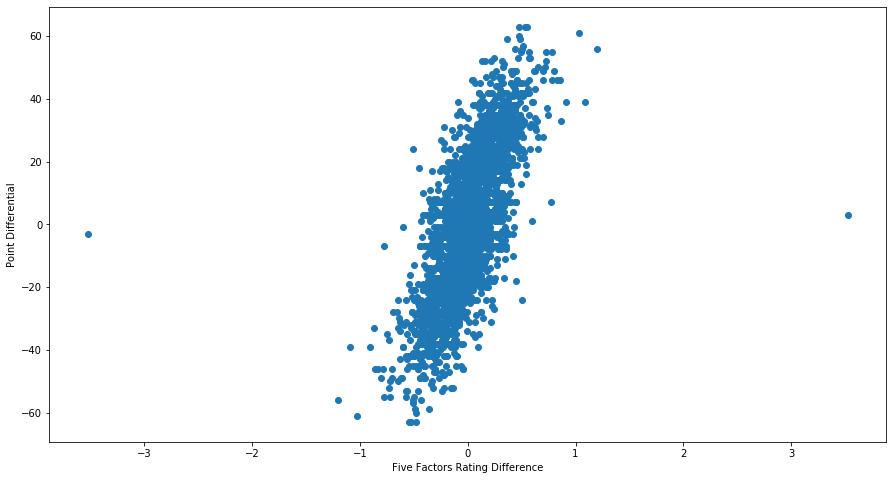

In [91]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [92]:
# Eliminate outliers
# basis = stored_game_boxes[stored_game_boxes['5FRDiff'] != 0]
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes['PtsDiff']))
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3) & (stored_game_boxes['pts_z_score'] < 3)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [94]:
outliers

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,23,-33,0.000019,0.500000,0.075000,23.000000,5.976471,1.150000,0.428571,0.700000,0.525424,0.71,0.00,0.461259,-0.867380,3.246785,1.514154
1,UCLA,56,33,0.999981,0.607843,0.313725,27.375000,9.886792,3.500000,1.000000,0.875000,0.666667,0.71,0.00,1.328638,0.867380,3.246785,1.514154
0,Georgia State,0,-56,0.000008,0.318182,0.106061,21.500000,4.209302,0.000000,0.500000,0.333333,0.400000,0.71,0.22,0.354474,-1.202598,4.501576,2.569473
1,Penn State,56,56,0.999992,0.714286,0.428571,61.000000,8.083333,5.600000,0.000000,0.800000,0.000000,0.49,-0.22,1.557071,1.202598,4.501576,2.569473
0,Kent State,3,-39,0.000005,0.245614,0.017544,30.333333,2.224138,0.125000,0.333333,0.250000,0.333333,1.42,0.22,0.248303,-0.907459,3.396811,1.789454
1,Louisville,42,39,0.999995,0.588235,0.274510,19.750000,10.431373,2.625000,0.714286,0.875000,0.595745,1.20,-0.22,1.155762,0.907459,3.396811,1.789454
0,Louisiana,10,-46,0.000012,0.379310,0.120690,25.600000,4.766667,1.000000,0.500000,0.400000,0.419355,0.22,0.22,0.471348,-0.831344,3.111898,2.110639
1,Mississippi State,56,46,0.999988,0.660377,0.245283,29.875000,9.283019,7.000000,1.000000,0.875000,0.693878,0.00,-0.22,1.302693,0.831344,3.111898,2.110639
0,Arizona State,38,3,0.131944,0.483333,0.150000,20.444444,7.209677,4.222222,0.666667,0.666667,0.555556,0.49,0.00,0.773085,3.524161,13.191678,0.137650
1,USC,35,-3,0.868056,0.491228,0.157895,22.181818,-81.473684,3.181818,0.666667,0.272727,0.681818,0.49,0.00,-2.751076,-3.524161,13.191678,0.137650


In [80]:
train_data.head()

,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Oregon State,27,-31,0.001059,0.416667,0.083333,29.166667,5.226667,1.125000,0.571429,0.583333,0.450980,1.59,0.66,0.407454,-0.067113,0.421267,1.422387
1,Colorado State,58,31,0.998941,0.576923,0.128205,40.100000,6.283951,2.900000,1.000000,0.900000,0.594595,0.93,-0.66,0.474566,0.067113,0.421267,1.422387
0,Hawai'i,38,3,0.678120,0.406250,0.093750,54.250000,5.061538,2.375000,0.500000,1.000000,0.406250,1.64,0.44,0.517675,0.096840,0.607866,0.137650
1,UMass,35,-3,0.321880,0.402985,0.134328,49.000000,5.343284,1.750000,0.833333,0.600000,0.489796,1.20,-0.44,0.420836,-0.096840,0.607866,0.137650
0,South Florida,42,20,0.964204,0.462366,0.075269,25.117647,4.849462,1.235294,0.800000,0.294118,0.686275,1.10,-1.32,0.224189,-0.211273,1.326165,0.917669


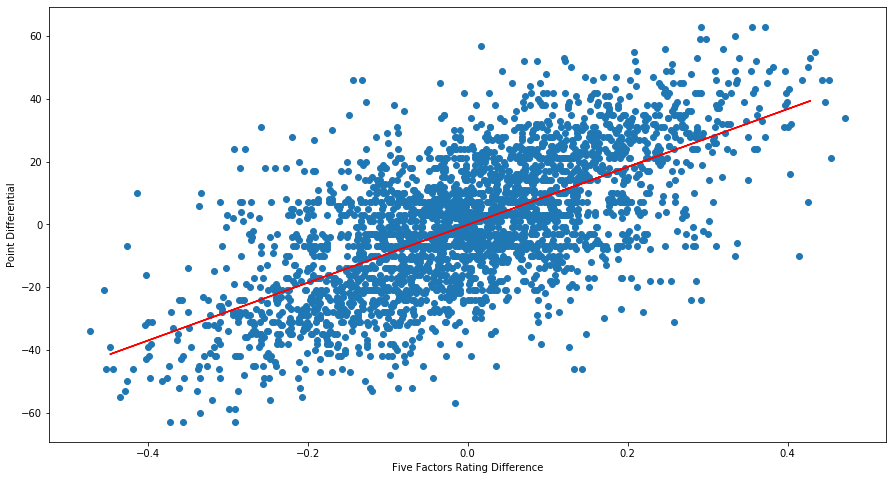

In [81]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [82]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

Linear Regression: y = 92.27354x + -0.14509


In [87]:
sample_box = calculate_box_score(401013183) # 2018 UVA at VT for sample
mu = yfit.mean()
std = yfit.std()

max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
print("")
proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {proj_point_diff}")
z = (proj_point_diff - mu) / std
print(f"Z score: {z}")
print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {100 * stats.norm.cdf(z)}%")

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3
5FRDiff for Virginia Tech: -0.02210053411500784

Proj MOV by 5FRDiff: Virginia Tech by -2.184381733546066
Z score: -0.1771536757489498
Win Prob for Virginia Tech: 42.969384072912916%


,Team,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,FP,YPP,PPD,OppEff,OppRate,OppSR,ExpTO,ExpTODiff,5FR,5FRDiff
0,Virginia,31,-3,0.875665,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,Virginia Tech,34,3,0.124335,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
